In [20]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split,ConcatDataset
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import scipy.io
import torchvision
import wandb

In [21]:
# wandb.login(key="a3ab9e880247c3575c105c3a5abb88ebc2eba87a")

In [22]:
transform = transforms.Compose([transforms.ToTensor()])
data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dt=datasets.MNIST(root='./data', train=False, transform=transform, download=True)
total_data=ConcatDataset([data,test_dt])

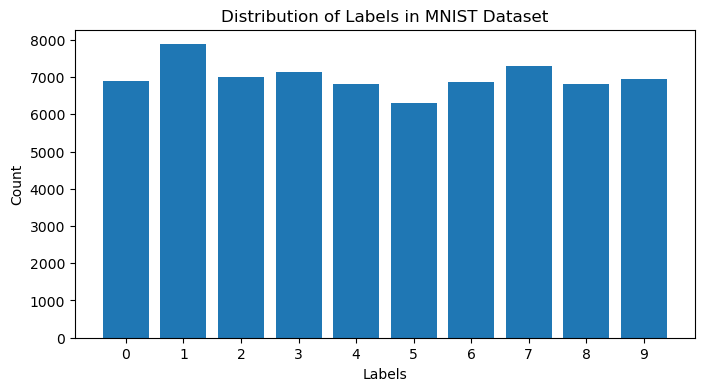

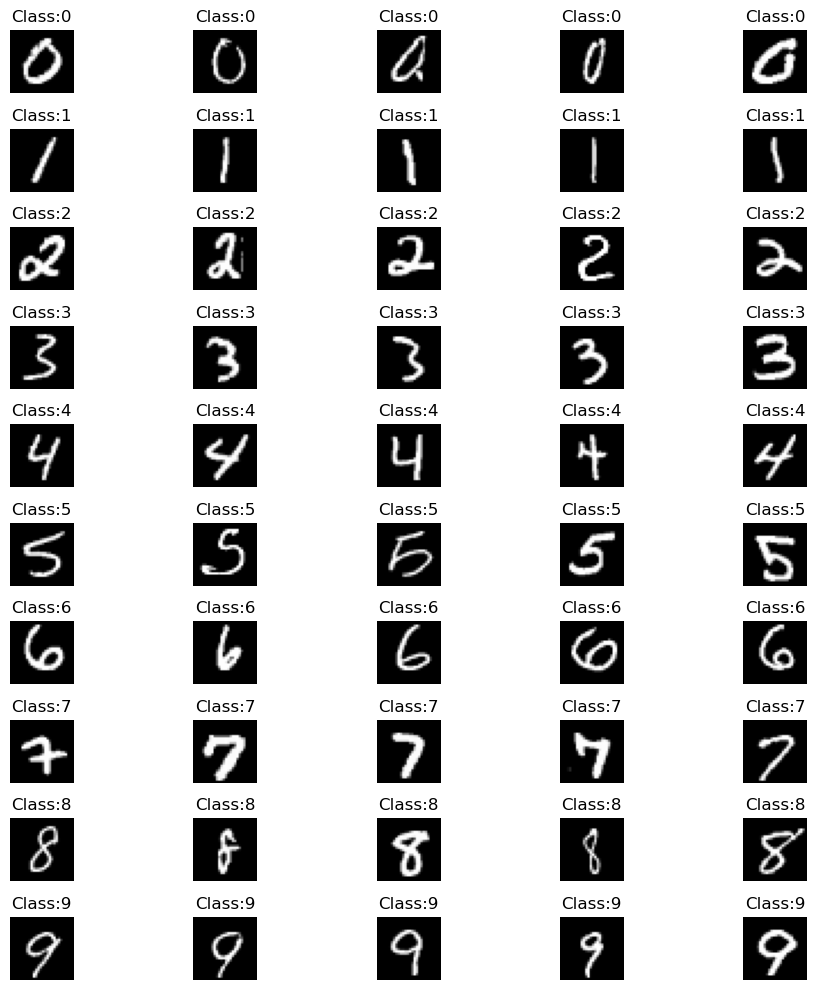

In [23]:
class_images = [[] for _ in range(10)]
label_count = [0] * 10
for image, label in total_data:
    class_images[label].append(image)
    label_count[label] += 1
plt.figure(figsize=(8, 4))
plt.bar(range(10), label_count)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in MNIST Dataset')
plt.xticks(range(10))
plt.show()

plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(5):
        plt.subplot(10, 5, i * 5 + j + 1)
        random_index = random.randint(0, len(class_images[i]) - 1)
        image = class_images[i][random_index][0]
        plt.imshow((image * 0.5 + 0.5).numpy(), cmap='gray')
        plt.title(f'Class:{i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
class CNNModel(nn.Module):
    def __init__(self,l_rate,batch_size,drop,ker_size,strd,padd):
        super(CNNModel, self).__init__()
        self.learning_rate=l_rate
        self.stride=strd
        self.ker_size=ker_size
        self.padding=padd
        self.batch_size=batch_size
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=ker_size, padding=padd)
        # we have 32 filters for layer conv1 so we will get 32 different outputs which will extract different features
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=ker_size, padding=padd)
        # 64 kernels
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(drop)
        fin_size=self.calculate_conv_output(self.calculate_conv_output(28,ker_size,padd,strd),ker_size,padd,strd)
        self.fc = nn.Linear(64 * fin_size * fin_size, 10)  # 10 output classes for MNIST
        self.softmax = nn.LogSoftmax(dim=1)
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
    def calculate_conv_output(self, in_size, ker_size, padd, strd):
        return ((in_size - ker_size + 2 * padd) // strd) + 1
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    def train(self,train_dataset,val_dataset,num_epochs):
        # nm=f"KS:{self.ker_size},S:{self.stride},P:{self.padding}"
        # wandb.init(
        #     project="CNN-MNIST-KerStrPad",
        #     config={
        #         "Learning Rate":self.learning_rate,
        #         "Epochs":num_epochs,
        #         "Batch Size":self.batch_size
        #     },
        #     name=nm
        # )
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        for epoch in range(num_epochs):
            ls=0.0
            k=0
            for images, labels in train_loader:
                self.optimizer.zero_grad()
                output = self.forward(images)
                loss = self.criterion(output, labels)
                ls+=loss
                loss.backward()
                k+=1
                self.optimizer.step()
            # Validation loop
            correct = 0
            total = 0
            for images, labels in val_loader:
                output = self.forward(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.2f}%')
            # wandb.log({'Validation Accuracy':val_accuracy,'Loss':ls/k})
    def eval(self,test_dataset):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        test_correct = 0
        test_total = 0
        pred=torch.empty(0)
        for images, labels in test_loader:
            output = self.forward(images)
            _, predicted = torch.max(output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            pred=torch.cat((pred,predicted),dim=0)
        test_accuracy = 100 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy:.2f}%')
        # wandb.log({'Test Accuracy':test_accuracy})
        return pred
    

In [25]:
torch.manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = random_split(data, [train_size, val_size])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

model = CNNModel(0.001,64,0.25,5,2,2)
model.train(train_dataset,val_dataset,5)
out=model.eval(test_dataset)

Epoch [1/5] - Validation Accuracy: 97.96%
Epoch [2/5] - Validation Accuracy: 98.28%
Epoch [3/5] - Validation Accuracy: 98.45%
Epoch [4/5] - Validation Accuracy: 98.53%
Epoch [5/5] - Validation Accuracy: 98.73%
Test Accuracy: 98.81%


In [26]:
# wandb part 
# stride=[2]
# ker_sizes=[3,5,9]
# pad=[1]

# for s in stride:
#     for ks in ker_sizes:
#         for pdd in pad:
#             model = CNNModel(0.001,64,0.25,ks,s,pdd)
#             model.train(train_dataset,val_dataset,5)
#             out=model.eval(test_dataset)
# wandb.finish()
# model = CNNModel(0.001,64,0.25,5,2,2)
# model.train(train_dataset,val_dataset,5)
# out=model.eval(test_dataset)
# model = CNNModel(0.001,64,0.25,3,2,1)
# model.train(train_dataset,val_dataset,5)
# out=model.eval(test_dataset)
# model = CNNModel(0.001,64,0.25,7,2,3)
# model.train(train_dataset,val_dataset,5)
# out=model.eval(test_dataset)

In [27]:
# # wandb part 
# lrates=[0.001,0.0001]
# batch_sizes=[32,64]
# epochs=[5,10]

# for lr in lrates:
#     for bs in batch_sizes:
#         for e in epochs:
#             model = CNNModel(lr,bs,0.25)
#             model.train(train_dataset,val_dataset,e)
#             out=model.eval(test_dataset)
# wandb.finish()

In [28]:
# drop_val=[0,0.25,0.5]
# for dv in drop_val:
#     model = CNNModel(0.001,32,dv)
#     model.train(train_dataset,val_dataset,10)
#     out=model.eval(test_dataset)

#### So, we can see that dropout can lead to loss of information. We see that corresponding epochs have lower accuracy for validation set for higher value of dropout.

## Noisy Dataset

In [29]:
data = scipy.io.loadmat('mnist-with-awgn.mat')
noisy_trainx=data['train_x']
noisy_trainy=data['train_y']
noisy_testx=data['test_x']
noisy_testy=data['test_y']
noisy_trainx=torch.tensor(noisy_trainx, dtype=torch.float32)
train_y=torch.tensor(noisy_trainy, dtype=torch.float32)
noisy_testx=torch.tensor(noisy_testx, dtype=torch.float32)
test_y=torch.tensor(noisy_testy, dtype=torch.float32)
train_x=noisy_trainx/255
test_x=noisy_testx/255
# plt.imshow(test_x[1].numpy().reshape(28, 28), cmap='gray')
# plt.title('Original')
# plt.axis('off')
# plt.show()

# def add_gaussian_noise(image, mean=0, std=0.15):
#     noise = torch.randn(image.size()) * std + mean
#     noisy_image = image + noise
#     return noisy_image
def add_gaussian_noise(image, noise_factor=0.5):
        noised_image = image + noise_factor * torch.randn_like(image)
        return torch.clamp(noised_image, 0., 1.)

noisy_givenset=[(image, ((label == 1).nonzero())[0,0].item()) for image, label in zip(test_x,test_y)]

In [30]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self,lrate):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lrate)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded
    def fit(self,trainset,num_epochs):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
        for epoch in range(num_epochs):
            for data in trainloader:
                images, _ = data
                noisy_images=torch.cat([add_gaussian_noise(image) for image in images], dim=0)
                self.optimizer.zero_grad()
                outputs = self.forward(noisy_images)
                loss = self.criterion(outputs, images)
                loss.backward()
                self.optimizer.step()
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    def eval(self,noisy_testset):
        noisy_testloader=torch.utils.data.DataLoader(noisy_testset, batch_size=64, shuffle=False)
        denoised_images = []
        with torch.no_grad():
            for data in noisy_testloader:
                noisy_images, label = data
                denoised = self.forward(noisy_images)
                denoised_images.append(denoised)
        denoised_images = torch.cat(denoised_images)
        return denoised_images

In [31]:
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
noisy_trainset = [(add_gaussian_noise(image), label) for image, label in trainset]
noisy_testset=[(add_gaussian_noise(image), label) for image, label in testset]

ae=DenoisingAutoencoder(0.0001)
ae.fit(trainset,15)
denoised_images=ae.eval(noisy_testset)

Epoch [1/15], Loss: 0.0637
Epoch [2/15], Loss: 0.0604
Epoch [3/15], Loss: 0.0473
Epoch [4/15], Loss: 0.0400
Epoch [5/15], Loss: 0.0365
Epoch [6/15], Loss: 0.0357
Epoch [7/15], Loss: 0.0341
Epoch [8/15], Loss: 0.0325
Epoch [9/15], Loss: 0.0302
Epoch [10/15], Loss: 0.0303
Epoch [11/15], Loss: 0.0300
Epoch [12/15], Loss: 0.0280
Epoch [13/15], Loss: 0.0282
Epoch [14/15], Loss: 0.0269
Epoch [15/15], Loss: 0.0269


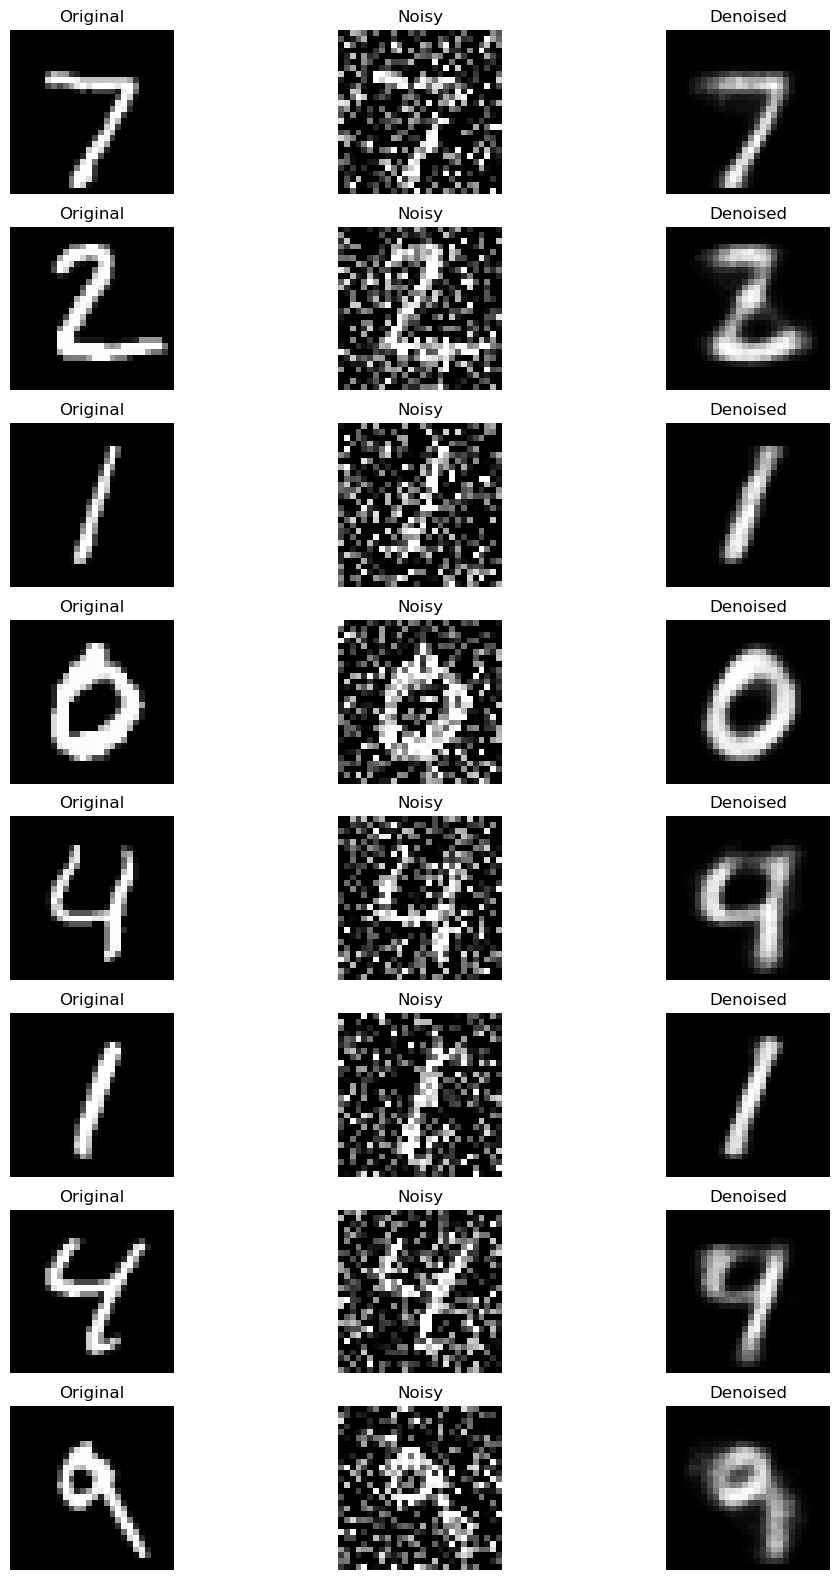

In [32]:
def show_images(original,noisy, denoised, n=8):
    plt.figure(figsize=(12, 20))  # Adjust the figure size as needed
    for i in range(n):
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(original[i].numpy().reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(noisy[i].numpy().reshape(28, 28), cmap='gray')
        plt.title('Noisy')
        plt.axis('off')

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(denoised[i].numpy().reshape(28, 28), cmap='gray')
        plt.title('Denoised')
        plt.axis('off')
    plt.show()
    
show_images(testset.data,[x[0] for x in noisy_testset], denoised_images)
# denoised_images=ae.eval(noisy_givenset)
# show_images(0,[x[0] for x in noisy_givenset],denoised_images)

In [34]:
new_testset_noisy=[(a.reshape(1, 28, 28), torch.tensor(b)) for a, b in noisy_testset]
val_dataset = new_testset_noisy[:1000]
new_testset_noisy=new_testset_noisy[1000:]
model_noisy = CNNModel(0.001,64,0,3,2,1)
model_noisy.train(trainset,val_dataset,10)
out=model_noisy.eval(new_testset_noisy)

Epoch [1/10] - Validation Accuracy: 75.40%
Epoch [2/10] - Validation Accuracy: 70.20%
Epoch [3/10] - Validation Accuracy: 61.00%
Epoch [4/10] - Validation Accuracy: 55.80%
Epoch [5/10] - Validation Accuracy: 54.60%
Epoch [6/10] - Validation Accuracy: 54.60%
Epoch [7/10] - Validation Accuracy: 61.90%
Epoch [8/10] - Validation Accuracy: 65.90%
Epoch [9/10] - Validation Accuracy: 61.70%
Epoch [10/10] - Validation Accuracy: 62.20%
Test Accuracy: 60.01%


In [35]:
denoised_images=ae.eval(new_testset_noisy)
new_denoised_testset=[(a.reshape(1, 28, 28), b[1]) for a, b in zip(denoised_images,new_testset_noisy)]
out2=model_noisy.eval(new_denoised_testset)

Test Accuracy: 85.34%
